In [1]:
import cv2
import numpy as np
import operator
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

<br>
<br>

## Define Some helper functions:

<br>
<br>

In [2]:
def extract_cells_coordinates(square_img):
    cells_coodinates = np.zeros((81, 4), dtype=float)
    grid_side = square_img.shape[:1]
    cell_side = grid_side[0]/9
    k=0
    for i in range(9):
        for j in range(9):
            x1, y1 = (i * cell_side, j * cell_side) 
            x2, y2 = ((i + 1) * cell_side, (j + 1) * cell_side)
            cells_coodinates[k, :]=[x1, y1, x2, y2]
            k=k+1
    return cells_coodinates


def extract_clean_digit_area(img, coord):
    x1, y1, x2, y2=coord
    dig=img[int(x1):int(x2), int(y1):int(y2)]
    dig=dig[:, :, 1]
    dig3=cv2.resize(dig, (45, 45), interpolation=cv2.INTER_CUBIC)
    digit=dig3/np.max(dig3)
    digit=np.expand_dims(digit, axis=-1)
    return digit


def measure_distance(pt1, pt2):
    x = pt2[0] - pt1[0]
    y = pt2[1] - pt1[1]
    return np.sqrt((x ** 2) + (y ** 2))

<br>
<br>

# Load image and basic preprocessing:
<br>
<br>

We will treat the image as a grayscale apply gaussian blur and thresholding for noise corection. In this case and because we expect an important variantion of signal over the image area, we will use the adaptiveThreshold function.

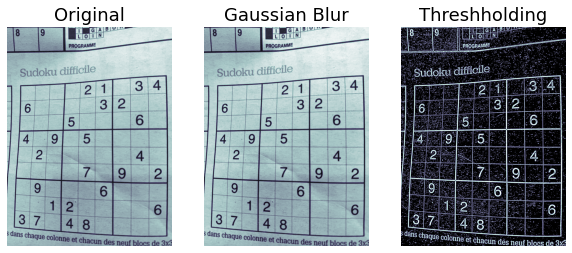

In [6]:
img = cv2.imread('sample_img/su4.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

#Plots:

f = plt.figure(figsize=(10,20))
f.add_subplot(1,3, 1)
plt.imshow(gray, cmap='bone')
plt.title('Original',fontsize=18)
plt.axis('off')
f.add_subplot(1,3, 2)
plt.imshow(blur, cmap='bone')
plt.title('Gaussian Blur',fontsize=18)
plt.axis('off')

f.add_subplot(1,3, 3)
plt.imshow(thresh, cmap='bone')
plt.title('Threshholding',fontsize=18)
plt.axis('off')
plt.savefig('plots/img_preprocessing.png', bbox_inches='tight')
plt.show()


<br>
<br>

# Detect Grid and crop:

<br>
<br>

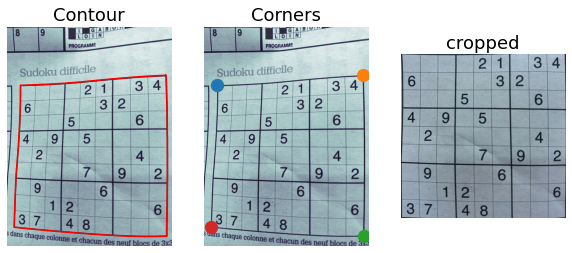

In [7]:
# Use cv2 contour to get the bigest contour and then get corners from it:

new_img, contours, hier = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
bigest_contour=contours[0]
polygon = bigest_contour
bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

corners=polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]
top_left, top_right, bottom_right, bottom_left = corners

#Crop image
src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

# Get the longest side in the rectangle
side = max([
    measure_distance(bottom_right, top_right),
    measure_distance(top_left, bottom_left),
    measure_distance(bottom_right, bottom_left),
    measure_distance(top_left, top_right)
])

dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
m = cv2.getPerspectiveTransform(src, dst)

cropped=cv2.warpPerspective(img, m, (int(side), int(side)))


#Plots:
f = plt.figure(figsize=(10,15))
f.add_subplot(1,3, 1)
plt.imshow(gray, cmap='bone')
plt.plot(bigest_contour[:, 0, 0], bigest_contour[:, 0, 1], 'r', 10)
plt.title('Contour',fontsize=18)
plt.axis('off')

f.add_subplot(1,3, 2)
for points in corners:
    plt.scatter(points[0], points[1], 150)
plt.imshow(gray, cmap='bone')
plt.title('Corners',fontsize=18)
plt.axis('off')

f.add_subplot(1,3, 3)
plt.imshow(cropped, cmap='bone')
plt.title('cropped',fontsize=18)
plt.axis('off')
plt.savefig('plots/grid_detection.png', bbox_inches='tight')

plt.show()

In [8]:



cells_coodinates = np.zeros((81, 4), dtype=float)
grid_side = cropped.shape[:1]
print(grid_side)
cell_side = grid_side[0]/9
k=0
#print(cell_side)

for i in range(1):
    for j in range(7):
        x1, y1 = (i * cell_side, j * cell_side) 
        x2, y2 = ((i + 1) * cell_side, (j + 1) * cell_side)
        x=[x1, x2, x2, x1, x1]
        y=[y1, y1, y2, y2, y1]
        #plt.plot(x, y, 'r')
        
        
        cells_coodinates[k, :]=[x1, y1, x2, int(y2)]
        k=k+1

(1505,)


<br>
<br>

# Get the digit areas:

<br>
<br>

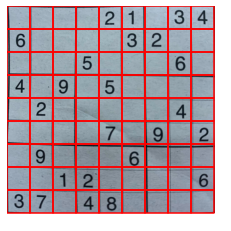

In [9]:

cells_coor=extract_cells_coordinates(cropped)
#np.shape(cells_coor)[0]
plt.imshow(cropped, cmap='bone')  
for i in range(0, np.shape(cells_coor)[0]):
    x1, y1, x2, y2=cells_coor[i, :]
    x=[x1, x2, x2, x1, x1]
    y=[y1, y1, y2, y2, y1]
    plt.plot(x, y, 'r')
plt.axis('off')
plt.savefig('plots/grid.png', bbox_inches='tight')
plt.show()  


In [10]:
#extract every digit as individual images for testing the Model:

total_dig=np.zeros((81, 45, 45, 1), dtype=float)#raw images
for i in range(0, np.shape(cells_coor)[0]):
    digit=extract_clean_digit_area(cropped, cells_coor[i, :])
    total_dig[i, :, :, :]=digit


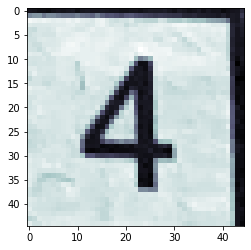

In [12]:
#Plot one exemple of digit area
imm=total_dig[8, :, :, 0]
plt.imshow(imm, cmap='bone')
plt.show()

In [32]:
np.save('unfiltered_im.npy', total_dig)
#np.save('labels.npy', np.array(true_mat))